In [18]:
import sys, os; sys.path.append(os.path.abspath(".."))
from src.data_prep import load_data
from src.features import build_features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit




In [3]:
df = load_data(save_processed=False)
df_fe = build_features(df)  

y = df_fe["home_price_index"]
X = df_fe.drop(columns=["home_price_index"])

mask=X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask], y.loc[mask]

# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

No missing values found.


In [15]:
dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, random_state=42)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, pred_dt)
r2_dt = r2_score(y_test, pred_dt)

print("Decision Tree MAE:", round(mae_dt, 3), "R²:", round(r2_dt, 3))


Decision Tree MAE: 6.991 R²: 0.959


In [12]:
tscv = TimeSeriesSplit(n_splits=5)
alphas = [0.1, 1, 10]

ridge_cv = RidgeCV(alphas=alphas, cv=tscv)
ridge_cv.fit(X_train, y_train)
pred_ridge = ridge_cv.predict(X_test)

mae_ridge = mean_absolute_error(y_test, pred_ridge)
r2_ridge = r2_score(y_test, pred_ridge)

print("Ridge Regression MAE:", round(mae_ridge, 3), "R²:", round(r2_ridge, 3), "Alpha:", ridge_cv.alpha_)

Ridge Regression MAE: 3.704 R²: 0.989 Alpha: 1.0


Text(0, 0.5, 'Home Price Index (HPI)')

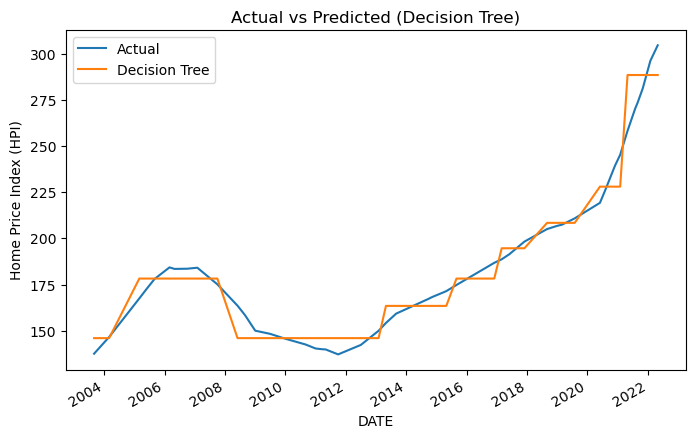

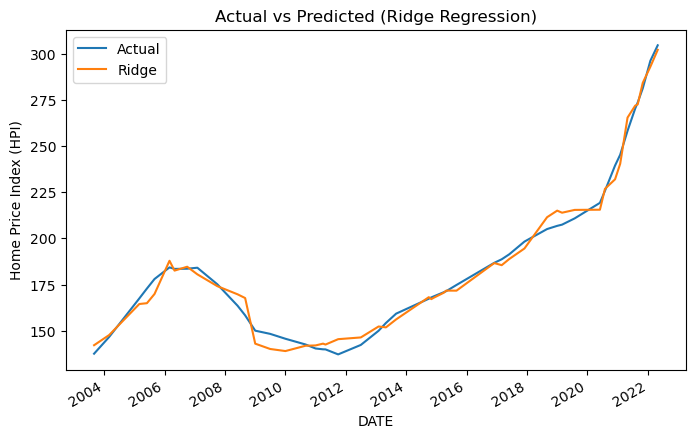

In [16]:
compare = pd.DataFrame(
    {"Actual": y_test, "Decision Tree": pred_dt, "Ridge": pred_ridge},
    index=y_test.index
).sort_index()

# Decision Tree vs Actual
ax = compare[["Actual", "Decision Tree"]].plot(figsize=(8, 5), title="Actual vs Predicted (Decision Tree)")
ax.set_xlabel("DATE")
ax.set_ylabel("Home Price Index (HPI)")

# Ridge vs Actual
ax = compare[["Actual", "Ridge"]].plot(figsize=(8, 5), title="Actual vs Predicted (Ridge Regression)")
ax.set_xlabel("DATE")
ax.set_ylabel("Home Price Index (HPI)")


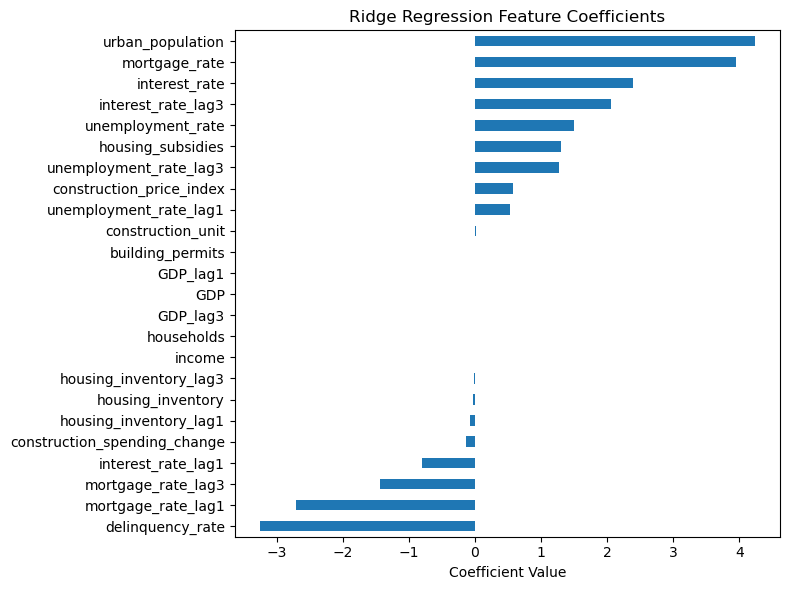

In [17]:
# Feature importance
coef_series = pd.Series(ridge_cv.coef_, index=X_train.columns)
coef_series.sort_values().plot(kind="barh", figsize=(8, 6), title="Ridge Regression Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


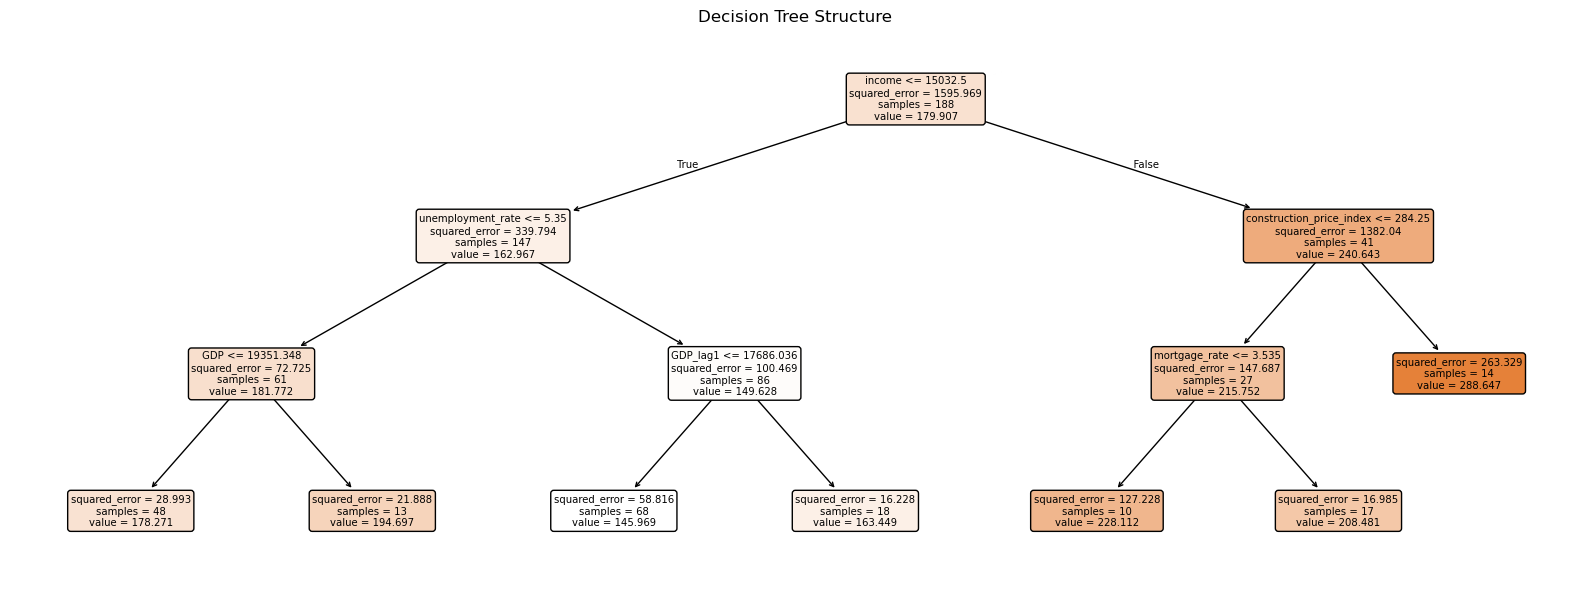

In [19]:
# Decision tree visual
plt.figure(figsize=(16, 6))
plot_tree(dt, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree Structure")
plt.tight_layout()
plt.show()